In [1]:
using DifferentialEquations
using DifferentialEquations.EnsembleAnalysis
using StatsBase, DataFrames
using Parameters, Plots, BenchmarkTools

┌ Info: Precompiling DifferentialEquations [0c46a032-eb83-5123-abaf-570d42b7fbaa]
└ @ Base loading.jl:1186


### Jump Problem Setup

In [2]:
# L11-23 from src/single_jump_instead_of_many.jl
function affect!(integrator)
  n = rand(1:integrator.p.N)
  n2 = rand(1:integrator.p.N)
  integrator.u[n] = max(integrator.u[n], integrator.u[n2])
end

function μ_SDE(du,u,p,t)
  du .= p.μ
end

function σ_SDE(du,u,p,t)
  du .= p.σ
end

σ_SDE (generic function with 1 method)

In [3]:
params = @with_kw (
    μ = 0.01, # mean
    σ = 0.1, # drift
    N = 10, # num particles
    β = 0.2, # rate parameter
    t = 0.:0.01:10., # saveat
    moments = Array{Array{Float64, 1}, 1}() # don't change this
    )

p = params()

(μ = 0.01, σ = 0.1, N = 10, β = 0.2, t = 0.0:0.01:10.0, moments = Array{Float64,1}[])

In [4]:
x_iv = rand(p.N)  # just draws from the inital condition

prob = SDEProblem(μ_SDE, σ_SDE, x_iv ,(0.0, p.t[end]), p)
rate(u,p,t) = p.β*p.N
jump = ConstantRateJump(rate,affect!)
jump_prob = JumpProblem(prob,Direct(),jump)

JumpProblem with problem SDEProblem and aggregator Direct
Number of constant rate jumps: 1
Number of variable rate jumps: 0


### Callback Setup

In [5]:
function save_func(u, t, integrator) 
    if length(integrator.p.moments) == 0 
        g = 0.
    else
        g = mean(u) - integrator.p.moments[end][2]
    end            
    moments = [minimum(u), mean(u), maximum(u), g]
    push!(integrator.p.moments, moments) 
end

save_func (generic function with 1 method)

In [6]:
cb = FunctionCallingCallback(save_func;
                 funcat=p.t,
                 func_everystep=false,
                 func_start = true,
                 tdir=1);

### Ensemble Setup

In [7]:
function output_func(sol, i)
    resize!(sol.t, 0)
    resize!(sol.u, 0)
    append!(sol.t, sol.prob.p.t) # or something like that... need the `t` values we used for the moments
    append!(sol.u, sol.prob.p.moments)
    return (sol, false)
end

output_func (generic function with 1 method)

In [8]:
ensemble_prob = EnsembleProblem(prob, output_func = output_func)

EnsembleProblem with problem SDEProblem

### Solve and Plot

In [9]:
sim = solve(ensemble_prob, SRIW1(), EnsembleSerial(), trajectories = 2, callback = cb, save_everystep = false);

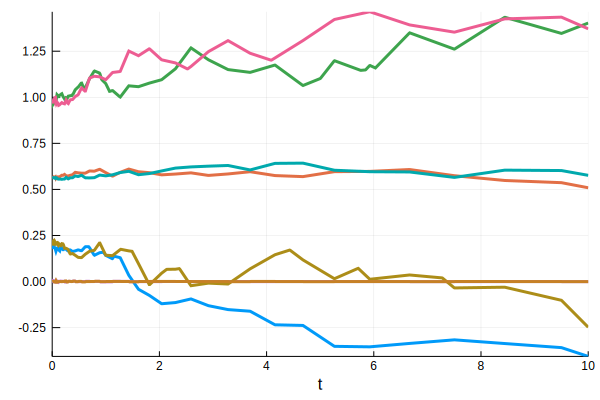

In [10]:
plot(sim)

In [11]:
summ = EnsembleSummary(sim)

EnsembleSolution Solution of length 1001 with uType:
Float64

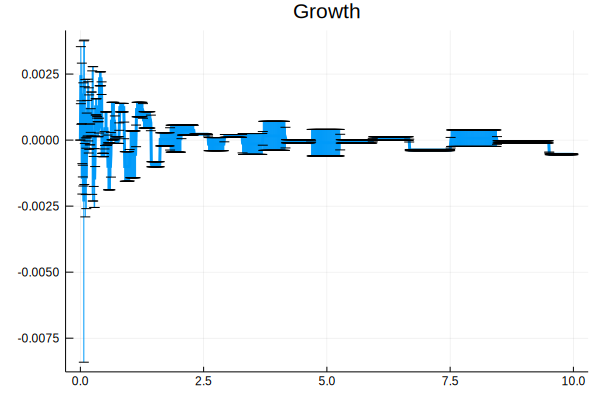

In [12]:
plot(summ, idxs = [4], error_style = :bars, title = "Growth")

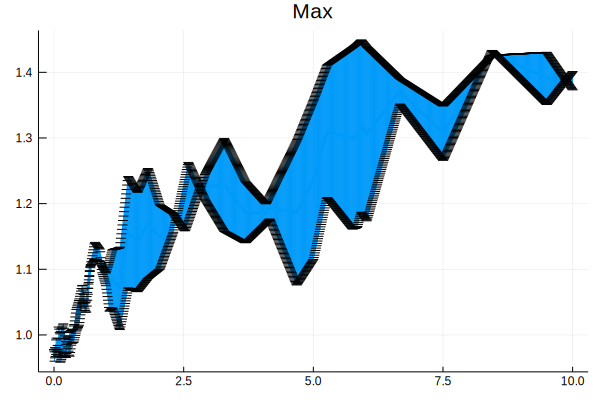

In [13]:
plot(summ, idxs = [3], error_style = :bars, title = "Max")

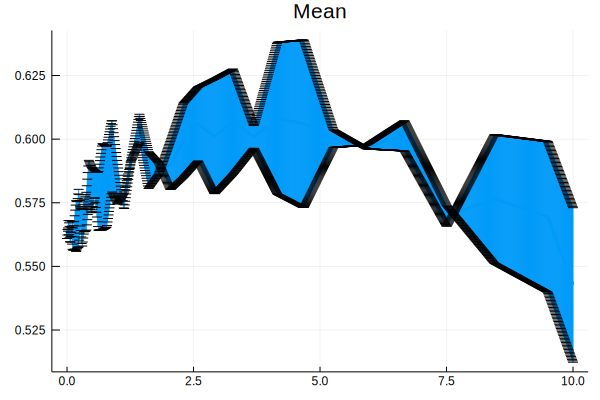

In [15]:
plot(summ, idxs = [2], error_style = :bars, title = "Mean")

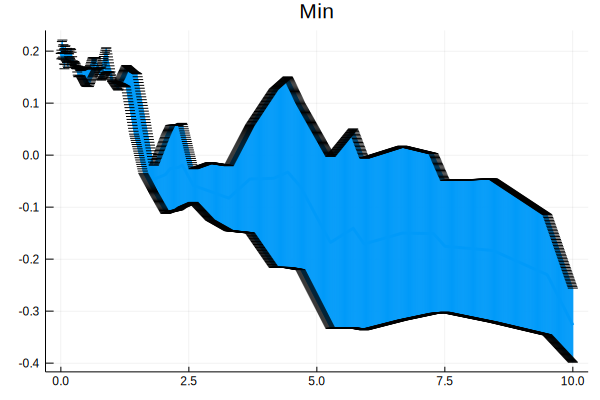

In [16]:
plot(summ, idxs = [1], error_style = :bars, title = "Min")